In [ ]:
#Importing all the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

%matplotlib inline

In [354]:
df1 = pd.read_csv('train.csv')             #loading the train.csv dataset
print(f'\nShape of train.csv {df1.shape}\n') #Shape of the train.csv dataset
df1.head(5)                                   #Checking the first 10 columns of the dataset.


Shape of train.csv (27481, 10)



,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [259]:
df1.info()           #Checking the column names and thier datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


There is a row with no text and selected_text data. So removing this data point from this huge dataset, doesn't effect much.

In [260]:
df2 = df1.copy()
df2.dropna(axis=0,inplace=True)      #Dropping the rows that containing null values.
print(f'Shape of df2 : {df2.shape}')  #Rechecking the shape of the dataset

Shape of df2 : (27480, 10)


The selected_text column is containing links, and special characters. For better model training I'll be removing these both from each data point of the selected_text column.

For removing the links and special characters I'll use regular expression library.
Also, I found that few stopwords in the selected text, I feel that the selected_text column is mostly similar to the text column for few data points. Here I will also remove the stopwords from the selected_text column

In [261]:
#Importing regular expression library
import re      #regular expression
import nltk    #natural language toolkit
from nltk.corpus import stopwords   #Stopwords are the words which are less meaningfull for analyzing the text. These words occur more regularly.
from nltk.stem.porter import PorterStemmer    #This is useful for stemming, means removing the precedding and succeding parts of a word, like this gives us the root word
## example : erasing -> erase

stemmer = PorterStemmer()

#Let's make a function and then apply it to the column

def review(text):
    #First we will remove the links from the text
    text_without_link = re.sub(r'http\S+', '', text)

    #Now we will remove special characteristics.
    reviewed = re.sub('[^a-zA-Z0-9]',' ',text_without_link)  #link.get_text()
    #converting all alphabets into lower case, then removing the spaces preceeding and succeeding a complete sentence.
    reviewed = reviewed.lower().strip().split()  
    reviewed = [stemmer.stem(i) for i in reviewed if not i in stopwords.words('english')]
    reviewed = ' '.join(reviewed)

    return reviewed


In [262]:
print("Applying the review function to the selected_text column")
df2['selected_text'] = df2['selected_text'].apply(review)
print("\n\nDone!")

Applying the review function to the selected_text column


Done!


In [263]:
df2.head(10)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going",respond go,neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,sooo sad,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bulli,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leav alon,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",son,negative,noon,60-70,Angola,32866272,1246700.0,26
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,shameless plug best ranger forum earth,neutral,night,70-100,Antigua and Barbuda,97929,440.0,223
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,morning,0-20,Argentina,45195774,2736690.0,17
7,50e14c0bb8,Soooo high,soooo high,neutral,noon,21-30,Armenia,2963243,28470.0,104
8,e050245fbd,Both of you,,neutral,night,31-45,Australia,25499884,7682300.0,3
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,wow u becam cooler,positive,morning,46-60,Austria,9006398,82400.0,109


Most common words used in the tweets : 

In [278]:
text_together = " ".join(df2['text'])

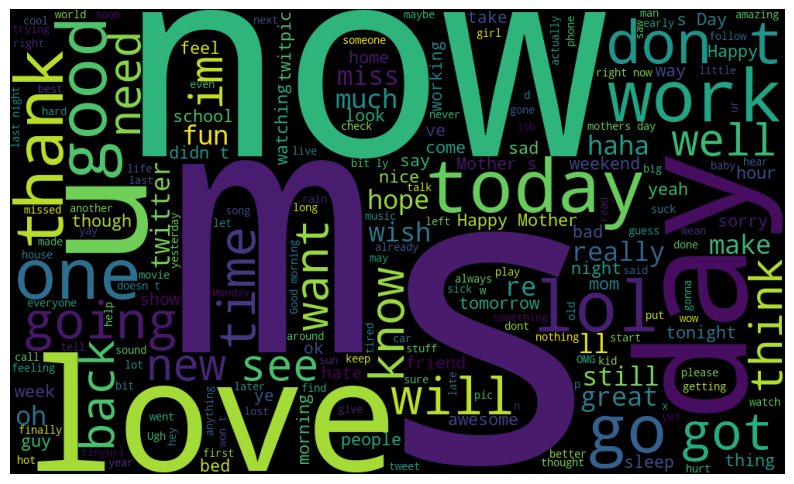

In [280]:
cloud = WordCloud(width=1000, height=600).generate(text_together)
plt.figure(figsize=(10,10))
plt.imshow(cloud)
plt.axis('off')    #to hide the axis of the wordcloud
plt.show()

Sentiment Count : 

In [265]:
df2['sentiment'].value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


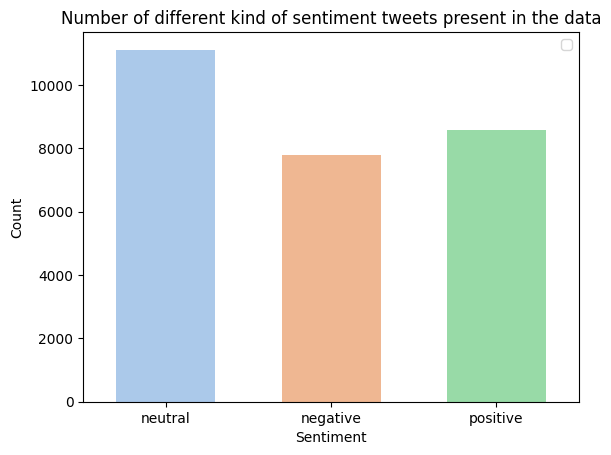

In [268]:
sns.countplot(x='sentiment',data=df2,hue='sentiment',palette='pastel',width=0.6)          
#plt.xticks(rotation=90)
plt.legend()
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Number of different kind of sentiment tweets present in the data')
plt.show()

The above output snippet shows that positive reviews and negative review are nealry smae but both are less than neutral reviews.

Renaming the sentiment names into numbers.

In [283]:
df2['sentiment'].replace(['neutral','positive','negative'],[0,1,-1],inplace=True)
df2.head(1)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),combined_content
0,cb774db0d1,"I`d have responded, if I were going",respond go,0,morning,0-20,Afghanistan,38928346,652860.0,60,morning afghanistan respond go


Time of Tweet

In [269]:
df2['Time of Tweet'].value_counts()

Time of Tweet
morning    9161
noon       9160
night      9159
Name: count, dtype: int64

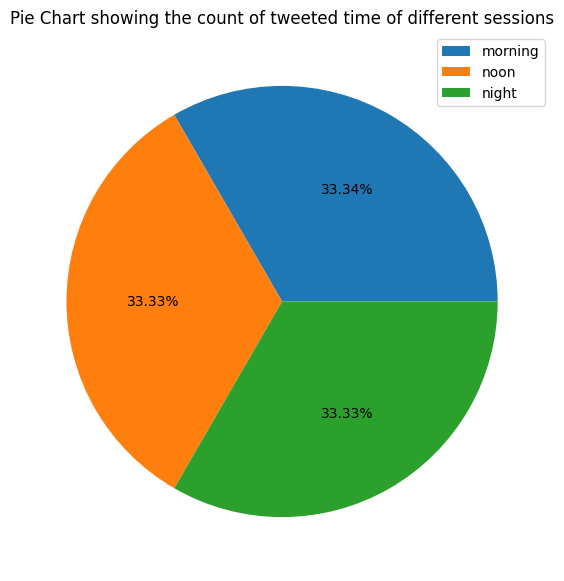

In [270]:
plt.figure(figsize=(7,7))
plt.pie(df2['Time of Tweet'].value_counts(), autopct="%1.2f%%")
plt.legend(df2['Time of Tweet'].values)
plt.title('Pie Chart showing the count of tweeted time of different sessions')
plt.show()

Checking the Age column

In [274]:
df2['Age of User'].value_counts()

Age of User
0-20      4581
21-30     4580
46-60     4580
60-70     4580
70-100    4580
31-45     4579
Name: count, dtype: int64

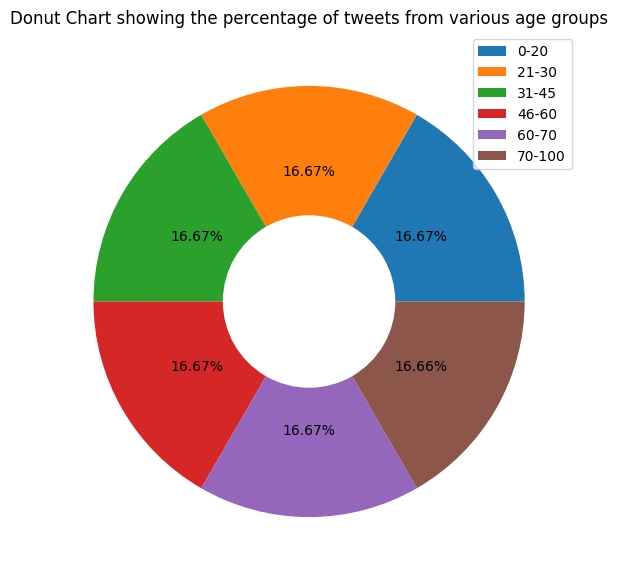

In [277]:
#Donut chart
plt.figure(figsize=(7,7))
plt.pie(df2['Age of User'].value_counts(), autopct="%1.2f%%", wedgeprops=dict(width=0.6))
plt.legend(df2['Age of User'].values)
plt.title('Donut Chart showing the percentage of tweets from various age groups')
plt.show()

The number of tweets from all age groups is same, so this feature doesn;t give us any extra information.

Creating a new column by combining selected_text, country and time of tweet columns.

In [281]:
#before adding the columns, they were converted into lower case, so that our model will not encounter any issues in dealing similar words in uppercase and lowercase.
df2['combined_content'] = df2['Time of Tweet'].str.lower() + " "+ df2['Country'].str.lower() + " " + df2['selected_text'] 
df2.head(1)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),combined_content
0,cb774db0d1,"I`d have responded, if I were going",respond go,0,morning,0-20,Afghanistan,38928346,652860.0,60,morning afghanistan respond go


Seperatng the count of different types of reviews of each country.

In [285]:
df3 = df2.pivot_table(index='Country',columns='sentiment',aggfunc='size')
df3.columns = ['Negative_Count','Neutral_Count','Positive_Count']
df3.insert(0,'Country',df3.index)
df3.reset_index(drop=True,inplace=True)
df3['Total'] = df3['Negative_Count']+df3['Neutral_Count']+df3['Positive_Count']
df3.head()


,Country,Negative_Count,Neutral_Count,Positive_Count,Total
0,Afghanistan,40,66,43,149
1,Albania,47,59,43,149
2,Algeria,51,55,43,149
3,Andorra,47,54,48,149
4,Angola,48,54,47,149


In [286]:
#Country with most negative reviews
df3.sort_values('Negative_Count',ascending=False).head(1)

,Country,Negative_Count,Neutral_Count,Positive_Count,Total
51,Egypt,55,53,41,149


In [287]:
#Country with most neutral reviews
df3.sort_values('Neutral_Count',ascending=False).head(1)

,Country,Negative_Count,Neutral_Count,Positive_Count,Total
21,Bosnia and Herzegovina,35,75,39,149


In [288]:
#Country with most positive reviews
df3.sort_values('Positive_Count',ascending=False).head(1)

,Country,Negative_Count,Neutral_Count,Positive_Count,Total
14,Barbados,34,53,62,149


In our dataset, I feel that the columns 'textID', 'Population','Land', 'Density' doesn't play an important role for our analysis. Also I've made a new column consisting of selected_text, Time of Tweet and Country columns in a new column, so these columns will also be removed.
So for now I'll be dropping these columns from our dataset.


In [289]:
df2.drop(['textID','selected_text','Population -2020', 'Land Area (Km²)','text','Density (P/Km²)','Country','Age of User','Time of Tweet'],axis=1,inplace=True)

In [290]:
df2.head(1)

,sentiment,combined_content
0,0,morning afghanistan respond go


word cloud helps us in finding the modt common words used in a string.

Here we need to give the data in one entire string only, so I will make one string containing all the combined content data using "join"

In [291]:
text_combined = " ".join(df2['combined_content'].astype('str'))
type(text_combined)

str

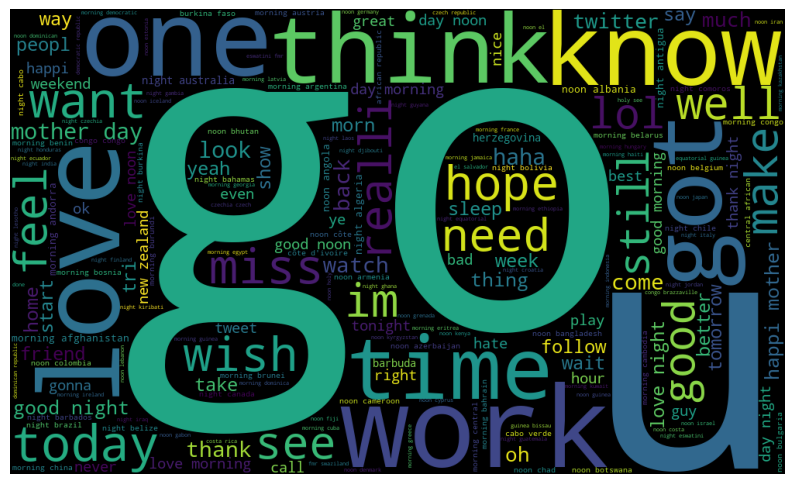

In [292]:
cloud = WordCloud(width=1000, height=600).generate(text_combined)
plt.figure(figsize=(10,10))
plt.imshow(cloud)
plt.axis('off')
plt.show()

So this is our final datasetwith two columns : sentiment and the content

The basic EDA is done. Let's deep dive!

In [294]:
#Seperating independent feature and the predictive feature.
x = df2['combined_content'].values
y = df2['sentiment'].values

In [295]:
#Vectorize the words
vector = TfidfVectorizer()

vector.fit(x)
x = vector.transform(x)


In [296]:
print(x)
print("\nShape of x : ",x.shape)

  (0, 9954)	0.7377914345899227
  (0, 7933)	0.18324843083328607
  (0, 5080)	0.35768617698181665
  (0, 593)	0.5423508186026961
  (1, 11036)	0.647536628304078
  (1, 10226)	0.47014081573643085
  (1, 8385)	0.19194353977192724
  (1, 690)	0.5681739222483662
  (2, 8314)	0.1752709037315871
  (2, 2025)	0.83243671388328
  (2, 704)	0.5256702651704003
  (3, 7933)	0.17768903562412122
  (3, 6942)	0.5433924659020257
  (3, 831)	0.5258969666983949
  (3, 743)	0.629748850762995
  (4, 11019)	0.7802141216243619
  (4, 8385)	0.20019861618955703
  (4, 844)	0.5926098535239791
  (5, 10548)	0.42681937177876234
  (5, 9699)	0.3987185215671638
  (5, 9224)	0.36584263434282915
  (5, 8314)	0.08395083307125477
  (5, 4665)	0.41038142816659506
  (5, 3847)	0.36584263434282915
  (5, 1527)	0.23498755527518583
  :	:
  (27473, 466)	0.686197044682562
  (27474, 8385)	0.23467018408171972
  (27474, 4970)	0.6946494739176292
  (27474, 4035)	0.6799941272459731
  (27475, 8314)	0.22363261594335404
  (27475, 7227)	0.7071975465802304
  (

Running the same for the test dataset.

In [297]:
df4 = pd.read_csv('test.csv')
print(df4.shape)

(4815, 9)


In [298]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            3534 non-null   object 
 1   text              3534 non-null   object 
 2   sentiment         3534 non-null   object 
 3   Time of Tweet     3534 non-null   object 
 4   Age of User       3534 non-null   object 
 5   Country           3534 non-null   object 
 6   Population -2020  3534 non-null   float64
 7   Land Area (Km²)   3534 non-null   float64
 8   Density (P/Km²)   3534 non-null   float64
dtypes: float64(3), object(6)
memory usage: 338.7+ KB


There are null values since the shape says there are 4815 datapoints but the info says there are 3534 non-null points.

In [299]:
df4.isna().sum()

textID              1281
text                1281
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km²)     1281
Density (P/Km²)     1281
dtype: int64

Out of a 4815 datapoints 1281 rows are empty in our testing dataset.
It appears that the exclusion of null columns from the testing dataset would not have any discernible impact, given that an adequate amount of data is available for model training. The quantity of testing examples is also commendable.

In [300]:
df4.dropna(axis=0,inplace=True)
print(f'Shape of the teting dataset : {df4.shape}')

Shape of the teting dataset : (3534, 9)


In [301]:
df4.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [302]:
df4.text

0       Last session of the day  http://twitpic.com/67ezh
1        Shanghai is also really exciting (precisely -...
2       Recession hit Veronique Branquinho, she has to...
3                                             happy bday!
4                  http://twitpic.com/4w75p - I like it!!
                              ...                        
3529    its at 3 am, im very tired but i can`t sleep  ...
3530    All alone in this old house again.  Thanks for...
3531     I know what you mean. My little dog is sinkin...
3532    _sutra what is your next youtube video gonna b...
3533     http://twitpic.com/4woj2 - omgssh  ang cute n...
Name: text, Length: 3534, dtype: object

The data in the text column contains word, links, and other characterters. The links and the characters doesn't will not be having a major role in our analysis. I'll be removing these links, unnecessary characters, and other common words in both text and the stopwords block.

In [303]:
print("Applying the review function to the selected_text column")
df4['selected_text'] = df4['text'].apply(review)
print("\n\nDone!")

Applying the review function to the selected_text column


Done!


In this dataset, there is no column like "selected_text". It is difficult to directly deal with the complete text of each tweet.
So I'll make a new column using the 'text' column and other functions.

In [304]:
df4['sentiment'].replace(['neutral','positive','negative'],[0,1,-1],inplace=True)
df4['combined_content'] = df4['Time of Tweet'].str.lower() + " " + df4['Country'].str.lower() + " " + df4['selected_text']


In [305]:
df5 = df4.pivot_table(index='Country',columns='sentiment',aggfunc='size')
df5.columns = ['-1','0','1']
df5.insert(0,'Country', df5.index)
df5.reset_index(drop=True,inplace=True)
df5['Total'] = df5['-1'] + df5['0'] + df5['1']
df5

,Country,-1,0,1,Total
0,Afghanistan,6.0,6.0,8.0,20.0
1,Albania,6.0,8.0,6.0,20.0
2,Algeria,8.0,9.0,3.0,20.0
3,Andorra,6.0,9.0,5.0,20.0
4,Angola,7.0,7.0,6.0,20.0
...,...,...,...,...,...
190,Venezuela,6.0,6.0,5.0,17.0
191,Vietnam,2.0,7.0,8.0,17.0
192,Yemen,6.0,6.0,5.0,17.0
193,Zambia,2.0,8.0,7.0,17.0


In [306]:
df4.drop(['textID','text','Population -2020', 'Land Area (Km²)','Density (P/Km²)','Country','Age of User','Time of Tweet','selected_text'],axis=1,inplace=True)

In [307]:
df4

,sentiment,combined_content
0,0,morning afghanistan last session day
1,1,noon albania shanghai also realli excit precis...
2,-1,night algeria recess hit veroniqu branquinho q...
3,1,morning andorra happi bday
4,1,noon angola like
...,...,...
3529,-1,noon nicaragua 3 im tire sleep tri
3530,1,night niger alon old hous thank net keep aliv ...
3531,-1,morning nigeria know mean littl dog sink depre...
3532,1,noon north korea sutra next youtub video gonna...


In [308]:
x_test = df4['combined_content'].values

In [309]:
#Vectorize the words using the same vectorizer used above.
x_test_v = vector.transform(x_test)

In [311]:
y_test = df4['sentiment'].values

In [313]:
x_train,x_val,y_train,y_val = train_test_split(x,y,train_size=0.8,stratify=y)

In [315]:
lr = LogisticRegression(solver='saga')

In [316]:
lr.fit(x_train,y_train)

LogisticRegression(solver='saga')

In [317]:
xtrain_predict = lr.predict(x_train)

print(xtrain_predict)

[ 1  1  1 ... -1  0 -1]


In [355]:
xtrain_accuracy = accuracy_score(y_train,xtrain_predict)
print("Accuracy Score of training set : ", xtrain_accuracy)

Accuracy Score of training set :  0.8767740174672489


In [320]:
xval_predict = lr.predict(x_val)

print(xval_predict)

[ 0  0  1 ... -1 -1  1]


In [356]:
xval_accuracy = accuracy_score(y_val,xval_predict)
print("Accuracy score of validation set : ", xval_accuracy)

Accuracy score of validation set :  0.8078602620087336


In [323]:
xtest_predict = lr.predict(x_test_v)

print(xtest_predict)

[ 0  1 -1 ...  0  0  1]


In [357]:
xtest_accuracy = accuracy_score(y_test,xtest_predict)
print("Accuracy Score of testing set : ", xtest_accuracy)

Accuracy Score of testing set :  0.5710243350311262


Taking a random element of the test array and checking the sentiment of the tweet.

In [334]:
X_new = x_test_v[100]

prediction = lr.predict(X_new)

if (prediction == 0):
    print("This tweet is a neutral tweet[0]")
else :
    if (prediction == 1):
      print("This tweet is a positive tweet[1]")
    else :
      print("This tweet is a negative tweet[-1]")


This tweet is a neutral tweet[0]


In [335]:
y_test[100]

0

Support Vector Machine

In [340]:
kernels = ['rbf','linear','poly','sigmoid']

for i in kernels:
    print("Kernel : ", i)
    model = SVC(kernel=i)
    model.fit(x_train,y_train)
    xtrain_pred = model.predict(x_train)
    xtrain_acc = accuracy_score(y_train,xtrain_pred)

    xval_predict = model.predict(x_val)
    xval_acc = accuracy_score(y_val,xval_predict)

    xtest_pred = model.predict(x_test_v)
    xtest_acc = accuracy_score(y_test,xtest_pred)
    
    print("Accuracy Score of predicted data : ", xtrain_acc)
    print("Accuracy Score of val data : ", xval_acc)
    print("Accuracy Score of test data : ", xtest_acc)
    print("----------------")
    

Kernel :  rbf


Accuracy Score of predicted data :  0.9511008005822417
Accuracy Score of val data :  0.8062227074235808
Accuracy Score of test data :  0.5577249575551783
----------------
Kernel :  linear
Accuracy Score of predicted data :  0.8913755458515283
Accuracy Score of val data :  0.8114992721979621
Accuracy Score of test data :  0.5764006791171478
----------------
Kernel :  poly
Accuracy Score of predicted data :  0.9879457787481805
Accuracy Score of val data :  0.7527292576419214
Accuracy Score of test data :  0.47113752122241087
----------------
Kernel :  sigmoid
Accuracy Score of predicted data :  0.8518922852983989
Accuracy Score of val data :  0.8078602620087336
Accuracy Score of test data :  0.5766836445953594
----------------


Naive Bayes : 

Here the training set and the testing set should contain the same number of labels.

In [341]:
gaussian = GaussianNB()

The input data must be of array

In [342]:
x_train_arr = x_train.toarray()
x_val_arr = x_val.toarray()
x_test_arr = x_test_v.toarray()


In [343]:
gaussian.fit(x_train_arr,y_train)

GaussianNB()

In [344]:
xtrain_pr = gaussian.predict(x_train_arr)
xtrain_g_acc = accuracy_score(y_train,xtrain_pr)

print("Accuracy Score of Training Data : ", xtrain_g_acc)

Accuracy Score of Training Data :  0.7353529839883551


In [347]:
gaussian.fit(x_val_arr,y_val)

GaussianNB()

In [350]:
xval_pr = gaussian.predict(x_val_arr)
xval_g_acc = accuracy_score(y_val,xval_pr)

print("Accuracy Score of Validation Data : ", xval_g_acc)

Accuracy Score of Validation Data :  0.8431586608442504


In [351]:
gaussian.fit(x_test_arr,y_test)

GaussianNB()

In [353]:
xtest_pr = gaussian.predict(x_test_arr)
xtest_g_acc = accuracy_score(y_test,xtest_pr)

print("Accuracy Score of Testing Data : ", xtest_g_acc)

Accuracy Score of Testing Data :  0.7911714770797963
